## Transfer Learning mobilenet using Tensorflow

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np, os, keras
from glob import glob
#import matplotlib.pyplot as plt

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/dataset/Br35H  Brain Tumor Detection 2020 binary/train'
valid_path = '/content/drive/MyDrive/dataset/Br35H  Brain Tumor Detection 2020 binary/val'
test_path = '/content/drive/MyDrive/dataset/Br35H  Brain Tumor Detection 2020 binary/test'

In [5]:
  # useful for getting number of output classes
folders = glob(os.path.join(train_path, '*'))

In [6]:
folders

['/content/drive/MyDrive/dataset/Br35H  Brain Tumor Detection 2020 binary/train/no',
 '/content/drive/MyDrive/dataset/Br35H  Brain Tumor Detection 2020 binary/train/yes']

In [7]:
import os
for folder in folders:
  name = folder.split("/")[-1]
  print(f"{name} folder has {len(os.listdir(folder))} samples")

no folder has 944 samples
yes folder has 1050 samples


In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 1994 images belonging to 2 classes.
Found 570 images belonging to 2 classes.


In [17]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 286 images belonging to 2 classes.


### Model

In [18]:
import tensorflow as tf
engine = tf.keras.applications.MobileNetV2(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

In [19]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(1, activation = 'sigmoid', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [23]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

Epoch 1/20
63/63 [==============================] - 602s 10s/step - loss: 0.2676 - accuracy: 0.8912 - val_loss: 0.5324 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 2/20
63/63 [==============================] - 464s 7s/step - loss: 0.1021 - accuracy: 0.9584 - val_loss: 2.1229 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9644
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
63/63 [==============================] - 491s 8s/step - loss: 0.1025 - accuracy: 0.9644 - val_loss: 3.6951 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 4/20
63/63 [==============================] - 468s 7s/step - loss: 0.0369 - accuracy: 0.9875 - val_loss: 1.4300 - val_accuracy: 0.8579 - lr: 2.5000e-04
Epoch 5/20
63/63 [==============================] - 474s 8s/step - loss: 0.0222 - accuracy: 0.9930 - val_loss: 0.4449 - val_accuracy: 0.9351 - lr: 2.5000e-04
Epoch 6/20
63/63 [==============================] - 476s 8s/st

In [24]:
import matplotlib.pyplot as plt

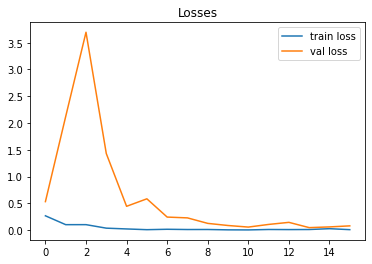

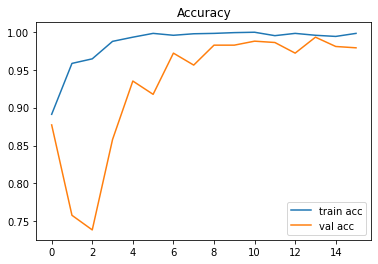

<Figure size 432x288 with 0 Axes>

In [25]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [26]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9851429350674152

In [27]:
# val accuracy
model.evaluate(val_set)

18/18 [==============================] - 25s 1s/step - loss: 0.0797 - accuracy: 0.9789


[0.079744853079319, 0.9789473414421082]

In [28]:
# test accuracy
model.evaluate(test_set)

9/9 [==============================] - 74s 9s/step - loss: 0.2634 - accuracy: 0.9615


[0.2633824944496155, 0.9615384340286255]

In [30]:
test_set.class_indices

{'no': 0, 'yes': 1}

In [32]:
test_set.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)

9/9 [==============================] - 19s 2s/step


In [33]:
result = []
for pre in prob:
  if pre<0.5:
    result.append(0)
  else:
    result.append(1)

result

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
print('\n')
print(classification_report(test_set.labels, result,target_names = ['no', 'yes'], digits=5))



              precision    recall  f1-score   support

          no    0.93103   0.99265   0.96085       136
         yes    0.99291   0.93333   0.96220       150

    accuracy                        0.96154       286
   macro avg    0.96197   0.96299   0.96153       286
weighted avg    0.96349   0.96154   0.96156       286



In [35]:

y_true = test_set.labels
y_pred = result
cm=confusion_matrix(y_true,y_pred)
cm

array([[135,   1],
       [ 10, 140]])

Text(69.0, 0.5, 'Predicted Values')

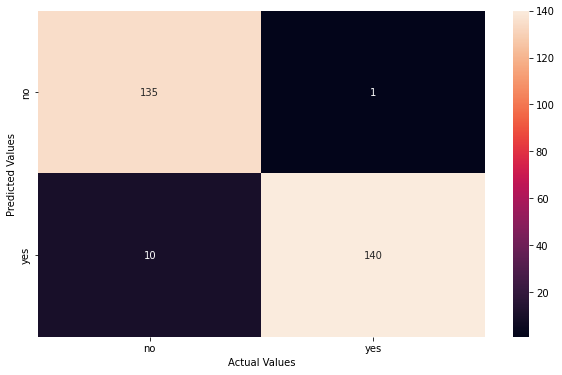

In [36]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d', xticklabels=['no','yes'],
                                  yticklabels= ['no','yes'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [37]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9615384615384616 0.9615384615384616 0.9615384615384616 0.9629901960784314 0.9249607768076341


In [38]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('brain_binary_mobilenetV2.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# model=load_model('/content/Transfer_Learning_Alzheimer_mobilenetV2.h5')

In [ ]:
# img=image.load_img('/content/drive/MyDrive/dataset/Alzheimer/test/Alzheimer_Non_Demented/non_1096.jpg',target_size=(224,224))
# x=image.img_to_array(img)
# x=x/255
# x.shape

In [ ]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [ ]:
# img_data = x.reshape(1,224,224,3)

In [ ]:
# result = model.predict(img_data)
# result = np.argmax(result, axis=-1)
# result

In [ ]:
# a=np.argmax(model.predict(img_data), axis=1)
# a

In [ ]:
# test_set.class_indices

In [ ]:
# a==2 # 0 = covid, 1 = normal, 2= Pneumonia

In [ ]:
# img_path = '/content/drive/MyDrive/breakHis_project/covid dataset/test/covid/COVID-1126.png'

# category = img_path.split('/')[-1].split('-')[0].upper()
# true = ''
# if category == 'COVID':
#     true = 'COVID'
# elif category == 'VIRAL PNEUMONIA':
#     true = 'Viral Pneumonia'
# else:
#     true = 'Normal'
# print(f'True value is : {true}')

In [ ]:
# image = load_img(img_path, target_size=(224, 224))
# img = img_to_array(image)/255
# img = img.reshape((1, 224, 224, 3))

# result = model.predict(img)
# result = np.argmax(result, axis=-1)
# print(result)
# print('Prediction is:')
# if result == 0:
#     print("COVID")
# elif result == 1:
#     print("Normal")
# else:
#     print("Viral Pneumonia ")
    
# plt.imshow(image)